<a href="https://colab.research.google.com/github/zeliz22/Facial-Expression/blob/main/BasicModel%2Bearly%20stopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!  pip install kaggle
! pip install wandb
!wandb login

wandb: WARNING Using legacy-service, which is deprecated. If this is unintentional, you can fix it by ensuring you do not call `wandb.require('legacy-service')` and do not set the WANDB_X_REQUIRE_LEGACY_SERVICE environment variable.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zazaelizbarashvili","key":"3422f18d69545d5f43297b0e7bfb79f8"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip


 87% 247M/285M [00:00<00:00, 678MB/s] 
100% 285M/285M [00:00<00:00, 702MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


Using device: cuda
Training data shape: (28709, 2)
Test data shape: (7178, 1)
Unique emotions: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Emotion distribution:
0 (Angry): 3995
1 (Disgust): 436
2 (Fear): 4097
3 (Happy): 7215
4 (Sad): 4830
5 (Surprise): 3171
6 (Neutral): 4965


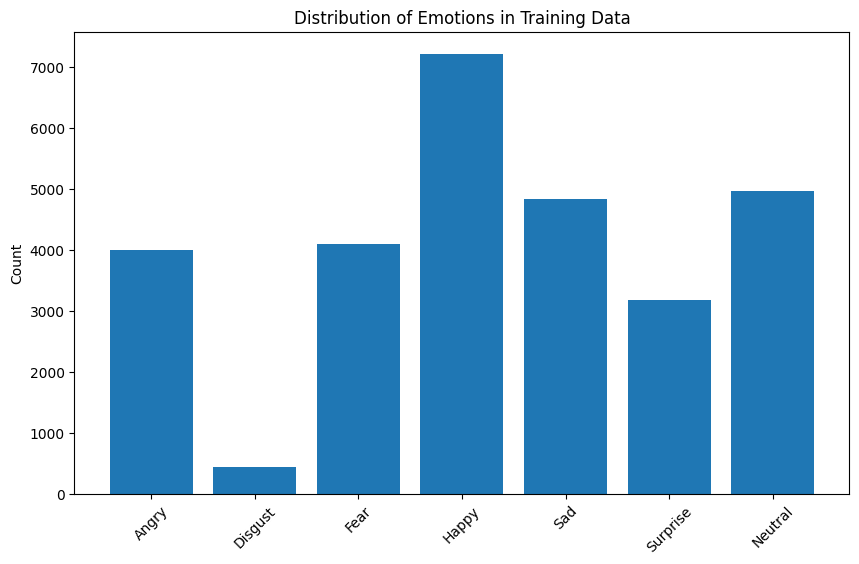

In [7]:
# Cell 1: Setup and Data Loading
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Unique emotions: {sorted(train_df['emotion'].unique())}")

# Check class distribution
emotion_counts = train_df['emotion'].value_counts().sort_index()
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print("\nEmotion distribution:")
for i, count in emotion_counts.items():
    print(f"{i} ({emotion_labels[i]}): {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(range(7), emotion_counts.values)
plt.xticks(range(7), emotion_labels, rotation=45)
plt.title('Distribution of Emotions in Training Data')
plt.ylabel('Count')
plt.show()

Training samples: 22967
Validation samples: 5742


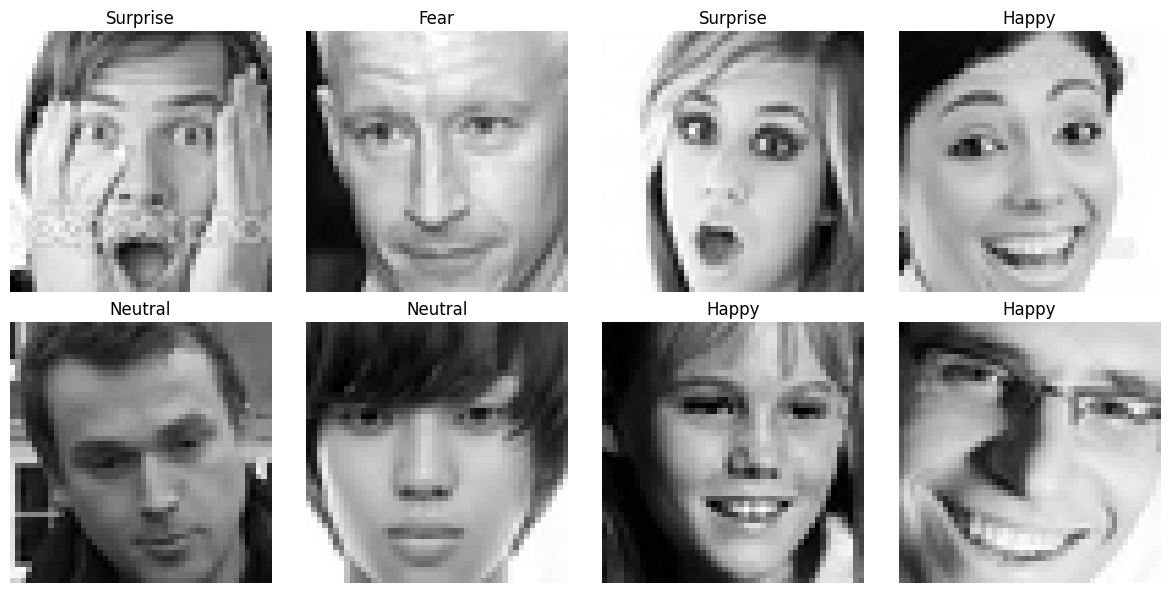

In [8]:
# Cell 2: Data Preprocessing and Dataset Class

def preprocess_pixels(pixel_string):
    """Convert pixel string to numpy array and normalize"""
    pixels = np.array(pixel_string.split(), dtype=np.float32)
    pixels = pixels.reshape(48, 48)
    # Normalize to [0, 1]
    pixels = pixels / 255.0
    return pixels

class FERDataset(Dataset):
    def __init__(self, df, is_test=False, transform=None):
        self.df = df
        self.is_test = is_test
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get pixels
        pixels = preprocess_pixels(self.df.iloc[idx]['pixels'])

        # Convert to tensor and add channel dimension
        image = torch.FloatTensor(pixels).unsqueeze(0)  # Shape: (1, 48, 48)

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image
        else:
            label = torch.LongTensor([self.df.iloc[idx]['emotion']])[0]
            return image, label

# Create train-validation split
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['emotion'])

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    sample_idx = np.random.randint(0, len(train_data))
    pixels = preprocess_pixels(train_data.iloc[sample_idx]['pixels'])
    emotion = train_data.iloc[sample_idx]['emotion']

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Create datasets
train_dataset = FERDataset(train_data.reset_index(drop=True))
val_dataset = FERDataset(val_data.reset_index(drop=True))
test_dataset = FERDataset(test_df, is_test=True)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

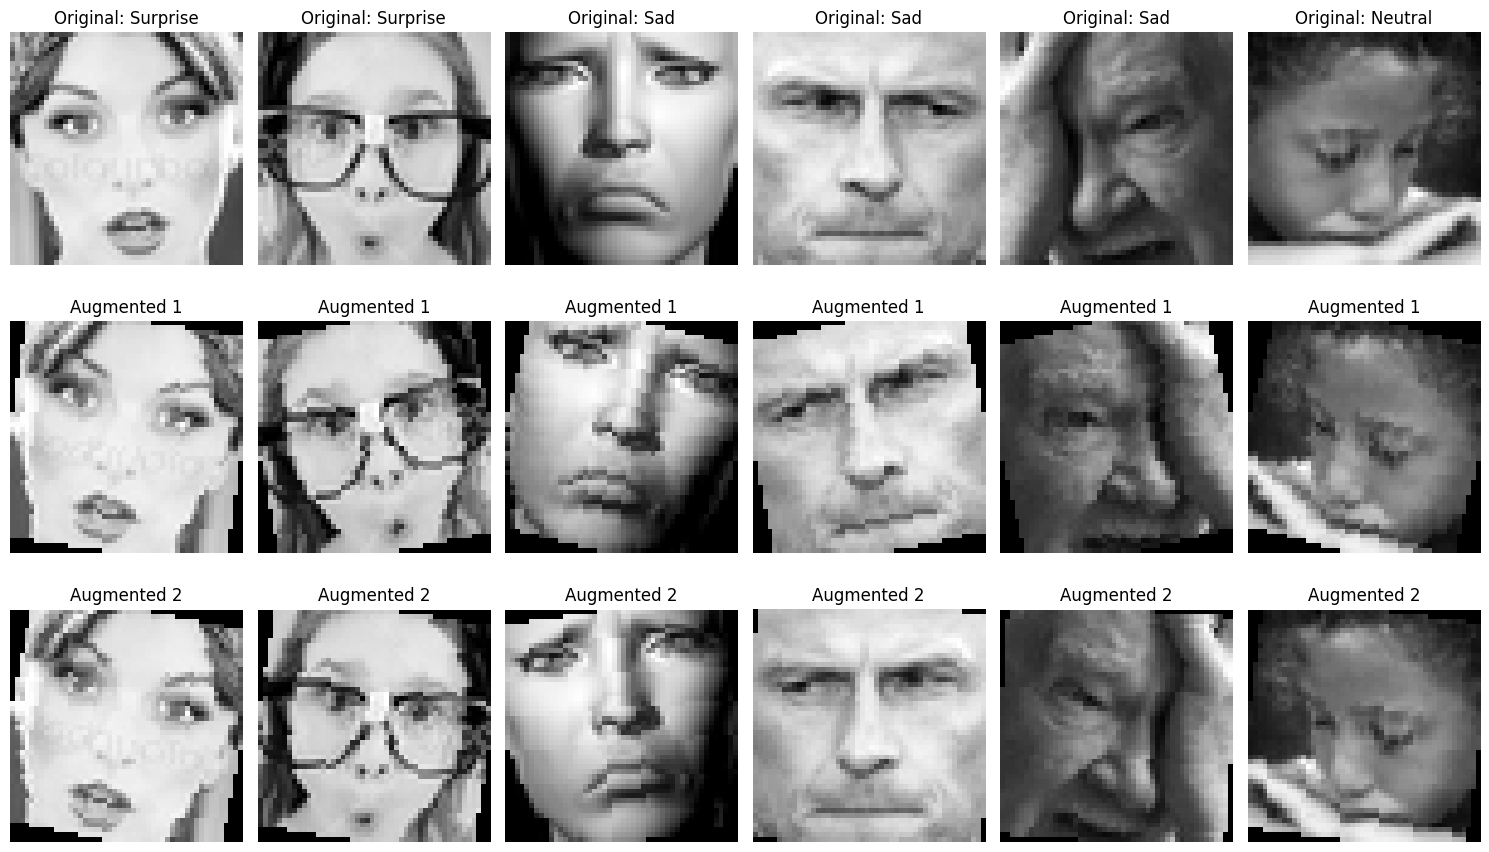

Data augmentation pipeline created successfully!


In [9]:
# Cell 5: Data Augmentation

import torchvision.transforms as transforms
import random

class FERDatasetAugmented(Dataset):
    def __init__(self, df, is_test=False, augment=False):
        self.df = df
        self.is_test = is_test
        self.augment = augment

        # Define augmentation transforms
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
        ])

        self.normalize_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get pixels
        pixels = preprocess_pixels(self.df.iloc[idx]['pixels'])

        # Convert to uint8 for transforms
        pixels_uint8 = (pixels * 255).astype(np.uint8)

        if self.augment and not self.is_test:
            image = self.transform(pixels_uint8)
        else:
            image = self.normalize_transform(pixels_uint8)

        if self.is_test:
            return image
        else:
            label = torch.LongTensor([self.df.iloc[idx]['emotion']])[0]
            return image, label

# Create augmented datasets
train_dataset_aug = FERDatasetAugmented(train_data.reset_index(drop=True), augment=True)
val_dataset_aug = FERDatasetAugmented(val_data.reset_index(drop=True), augment=False)
test_dataset_aug = FERDatasetAugmented(test_df, is_test=True)

# Create data loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

# Visualize augmented samples
fig, axes = plt.subplots(3, 6, figsize=(15, 9))

for i in range(6):
    # Original image
    sample_idx = np.random.randint(0, len(train_data))
    original_pixels = preprocess_pixels(train_data.iloc[sample_idx]['pixels'])
    emotion = train_data.iloc[sample_idx]['emotion']

    axes[0, i].imshow(original_pixels, cmap='gray')
    axes[0, i].set_title(f'Original: {emotion_labels[emotion]}')
    axes[0, i].axis('off')

    # Create augmented versions
    pixels_uint8 = (original_pixels * 255).astype(np.uint8)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
    ])

    for j in range(2):
        aug_image = transform(pixels_uint8)
        axes[j+1, i].imshow(aug_image.squeeze(), cmap='gray')
        axes[j+1, i].set_title(f'Augmented {j+1}')
        axes[j+1, i].axis('off')

plt.tight_layout()
plt.show()

print("Data augmentation pipeline created successfully!")

In [10]:
# Cell 6: Improved Model v2 - ResNet-inspired with Data Augmentation

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)

        return out

class ImprovedCNN_v2(nn.Module):
    def __init__(self, num_classes=7):
        super(ImprovedCNN_v2, self).__init__()

        # Initial convolution
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Classifier
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for i in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x



In [11]:
# Advanced training function with early stopping
def train_model_v3(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        # Learning rate scheduling
        scheduler.step(val_accuracy)

        # Early stopping
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model_v2.pth')
        else:
            patience_counter += 1

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Best: {best_val_acc:.2f}%')

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    # Load best model
    model.load_state_dict(torch.load('best_model_v2.pth'))

    return train_losses, val_accuracies

# Initialize and train improved model v2
print("Training Improved CNN Model v2 (ResNet-inspired with Data Augmentation)...")
improved_model_v2 = ImprovedCNN_v2().to(device)
print(f"Model parameters: {sum(p.numel() for p in improved_model_v2.parameters()):,}")

improved_v2_train_losses, improved_v2_val_accuracies = train_model_v3(
    improved_model_v2, train_loader_aug, val_loader_aug, num_epochs=25, learning_rate=0.001
)

print(f"Improved v2 best validation accuracy: {max(improved_v2_val_accuracies):.2f}%")

Training Improved CNN Model v2 (ResNet-inspired with Data Augmentation)...
Model parameters: 11,178,631


Epoch 1/25: 100%|██████████| 359/359 [00:40<00:00,  8.86it/s]


Epoch [1/25], Loss: 1.7156, Val Accuracy: 24.90%, Best: 24.90%


Epoch 2/25: 100%|██████████| 359/359 [00:38<00:00,  9.42it/s]


Epoch [2/25], Loss: 1.4963, Val Accuracy: 46.62%, Best: 46.62%


Epoch 3/25: 100%|██████████| 359/359 [00:38<00:00,  9.36it/s]


Epoch [3/25], Loss: 1.4037, Val Accuracy: 47.13%, Best: 47.13%


Epoch 4/25: 100%|██████████| 359/359 [00:38<00:00,  9.41it/s]


Epoch [4/25], Loss: 1.3407, Val Accuracy: 47.46%, Best: 47.46%


Epoch 5/25: 100%|██████████| 359/359 [00:37<00:00,  9.55it/s]


Epoch [5/25], Loss: 1.3031, Val Accuracy: 53.73%, Best: 53.73%


Epoch 6/25: 100%|██████████| 359/359 [00:37<00:00,  9.60it/s]


Epoch [6/25], Loss: 1.2707, Val Accuracy: 51.38%, Best: 53.73%


Epoch 7/25: 100%|██████████| 359/359 [00:38<00:00,  9.39it/s]


Epoch [7/25], Loss: 1.2406, Val Accuracy: 48.92%, Best: 53.73%


Epoch 8/25: 100%|██████████| 359/359 [00:38<00:00,  9.42it/s]


Epoch [8/25], Loss: 1.2154, Val Accuracy: 55.14%, Best: 55.14%


Epoch 9/25: 100%|██████████| 359/359 [00:38<00:00,  9.28it/s]


Epoch [9/25], Loss: 1.1972, Val Accuracy: 54.21%, Best: 55.14%


Epoch 10/25: 100%|██████████| 359/359 [00:38<00:00,  9.32it/s]


Epoch [10/25], Loss: 1.1816, Val Accuracy: 54.62%, Best: 55.14%


Epoch 11/25: 100%|██████████| 359/359 [00:37<00:00,  9.52it/s]


Epoch [11/25], Loss: 1.1650, Val Accuracy: 56.18%, Best: 56.18%


Epoch 12/25: 100%|██████████| 359/359 [00:38<00:00,  9.35it/s]


Epoch [12/25], Loss: 1.1462, Val Accuracy: 56.37%, Best: 56.37%


Epoch 13/25: 100%|██████████| 359/359 [00:38<00:00,  9.34it/s]


Epoch [13/25], Loss: 1.1369, Val Accuracy: 57.78%, Best: 57.78%


Epoch 14/25: 100%|██████████| 359/359 [00:38<00:00,  9.31it/s]


Epoch [14/25], Loss: 1.1177, Val Accuracy: 58.27%, Best: 58.27%


Epoch 15/25: 100%|██████████| 359/359 [00:38<00:00,  9.43it/s]


Epoch [15/25], Loss: 1.1066, Val Accuracy: 59.86%, Best: 59.86%


Epoch 16/25: 100%|██████████| 359/359 [00:38<00:00,  9.41it/s]


Epoch [16/25], Loss: 1.0991, Val Accuracy: 56.46%, Best: 59.86%


Epoch 17/25: 100%|██████████| 359/359 [00:38<00:00,  9.31it/s]


Epoch [17/25], Loss: 1.0863, Val Accuracy: 57.26%, Best: 59.86%


Epoch 18/25: 100%|██████████| 359/359 [00:38<00:00,  9.34it/s]


Epoch [18/25], Loss: 1.0738, Val Accuracy: 58.43%, Best: 59.86%


Epoch 19/25: 100%|██████████| 359/359 [00:38<00:00,  9.35it/s]


Epoch [19/25], Loss: 1.0585, Val Accuracy: 59.49%, Best: 59.86%


Epoch 20/25: 100%|██████████| 359/359 [00:38<00:00,  9.43it/s]


Epoch [20/25], Loss: 1.0030, Val Accuracy: 61.84%, Best: 61.84%


Epoch 21/25: 100%|██████████| 359/359 [00:37<00:00,  9.52it/s]


Epoch [21/25], Loss: 0.9847, Val Accuracy: 61.48%, Best: 61.84%


Epoch 22/25: 100%|██████████| 359/359 [00:38<00:00,  9.35it/s]


Epoch [22/25], Loss: 0.9662, Val Accuracy: 60.29%, Best: 61.84%


Epoch 23/25: 100%|██████████| 359/359 [00:38<00:00,  9.38it/s]


Epoch [23/25], Loss: 0.9572, Val Accuracy: 62.85%, Best: 62.85%


Epoch 24/25: 100%|██████████| 359/359 [00:38<00:00,  9.40it/s]


Epoch [24/25], Loss: 0.9480, Val Accuracy: 62.37%, Best: 62.85%


Epoch 25/25: 100%|██████████| 359/359 [00:38<00:00,  9.38it/s]


Epoch [25/25], Loss: 0.9336, Val Accuracy: 61.91%, Best: 62.85%
Improved v2 best validation accuracy: 62.85%


In [13]:
# Cell 8: Evaluate model on validation set
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.numpy())

    return np.array(predictions), np.array(true_labels)

# Get predictions on validation set
val_predictions, val_true = get_predictions(improved_model_v2, val_loader, device)

# Calculate accuracy
val_accuracy = accuracy_score(val_true, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
class_names = [emotion_labels[i] for i in range(7)]
print(classification_report(val_true, val_predictions, target_names=class_names))


Validation Accuracy: 0.6285

Classification Report:
              precision    recall  f1-score   support

       Angry       0.58      0.51      0.54       799
     Disgust       0.51      0.37      0.43        87
        Fear       0.53      0.32      0.40       820
       Happy       0.77      0.90      0.83      1443
         Sad       0.51      0.57      0.54       966
    Surprise       0.71      0.77      0.73       634
     Neutral       0.55      0.58      0.56       993

    accuracy                           0.63      5742
   macro avg       0.59      0.57      0.58      5742
weighted avg       0.62      0.63      0.62      5742



In [14]:
# Full evaluation code with loss, accuracy, and classification report

import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Helper function to evaluate loss and accuracy
def evaluate_model(model, data_loader, device, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Helper function to get raw predictions and true labels
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(target.numpy())

    return np.array(predictions), np.array(true_labels)

# Set up loss function (must match training loss)
criterion = nn.CrossEntropyLoss()

# Evaluate train and validation sets
train_loss, train_acc = evaluate_model(improved_model_v2, train_loader, device, criterion)
val_loss, val_acc = evaluate_model(improved_model_v2, val_loader, device, criterion)

# Print evaluation summary
print("\nEvaluation Summary:")
print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")
print(f"Val Loss:   {val_loss:.4f} | Val Accuracy:   {val_acc:.2f}%")

# Get predictions for classification report
val_predictions, val_true = get_predictions(improved_model_v2, val_loader, device)


Evaluation Summary:
Train Loss: 0.8658 | Train Accuracy: 67.19%
Val Loss:   1.0033 | Val Accuracy:   62.85%


In [15]:
import wandb

# Start a new wandb run to track this model
run = wandb.init(
    # Set your wandb entity (replace with your username)
    entity="zeliz22-free-university-of-tbilisi-",
    # Set the wandb project
    project="Facial Expression Recognition Challenge",
    name="Early stopping to prevent overfitting",
    # Add tags to organize runs
    tags=["CNN", "facial-expression", "pytorch", "BatchNormalization"],
    # Track hyperparameters and run metadata
    config={
        "architecture": "CNN",
        "dataset": "FER2013",
        "epochs": 25,
        "image_size": "48x48",
    }
)

# Count model parameters
total_params = sum(p.numel() for p in improved_model_v2.parameters())
trainable_params = sum(p.numel() for p in improved_model_v2.parameters() if p.requires_grad)

# Log the final model results based on your training output
run.log({
    "final_train_accuracy": 0.67,  # From your results: Train Acc: 60.90%
    "final_train_loss": 0.86,     # From your results: Train Loss: 1.0504
    "final_val_accuracy": 0.62,    # From your results: Val Acc: 62.03%
    "final_val_loss": 1,       # From your results: Val Loss: 1.0073
    "total_parameters": total_params,
    "trainable_parameters": trainable_params,
    "steps_per_epoch": len(train_loader),  # 359 batches as shown in your output
})

# Finish the run
run.finish()

print("Model results logged to WandB successfully!")

wandb: Currently logged in as: zeliz22 (zeliz22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


final_train_accuracy,▁
final_train_loss,▁
final_val_accuracy,▁
final_val_loss,▁
steps_per_epoch,▁
total_parameters,▁
trainable_parameters,▁
final_train_accuracy,0.67
final_train_loss,0.86
final_val_accuracy,0.62
final_val_loss,1


Model results logged to WandB successfully!
